# Assignment 5
Jan Widanka

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import seaborn as sns
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, GRU, SimpleRNN
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import keras_tuner as kt

## Short Exploratory Data Analysis

https://www.kaggle.com/datasets/maharshipandya/twitter-stocks-dataset

### Feature description

My data set contains 2259 observations. It has 7 features, which can be described as follows:

- $\textit{Date}$: the date for which the stock data is considered,
- $\textit{Open}$: the stock's opening price on given day,
- $\textit{High}$: the stock's highest price on given day,
- $\textit{Low}$: the stock's lowest price on given day,
- $\textit{Close}$: the stock's closing price on given day,
- $\textit{Adj Close}$: adjusted close price adjusted for splits and dividend,
- $\textit{Volume}$: measures the number of shares traded in a stock or contracts traded in futures or options.

In [6]:
twitter = pd.read_csv("twitter-stocks.csv")
twitter_df = pd.DataFrame(twitter)

In [7]:
twitter_df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-11-07,45.099998,50.090000,44.000000,44.900002,44.900002,117701670.0
1,2013-11-08,45.930000,46.939999,40.685001,41.650002,41.650002,27925307.0
2,2013-11-11,40.500000,43.000000,39.400002,42.900002,42.900002,16113941.0
3,2013-11-12,43.660000,43.779999,41.830002,41.900002,41.900002,6316755.0
4,2013-11-13,41.029999,42.869999,40.759998,42.599998,42.599998,8688325.0
5,2013-11-14,42.340000,45.669998,42.240002,44.689999,44.689999,11099433.0
6,2013-11-15,45.250000,45.270000,43.430000,43.980000,43.980000,8010663.0
7,2013-11-18,43.500000,43.950001,40.849998,41.139999,41.139999,12810624.0
8,2013-11-19,41.389999,41.900002,40.000000,41.750000,41.750000,7436616.0
9,2013-11-20,41.400002,41.750000,40.509998,41.049999,41.049999,5767325.0


In [8]:
twitter_df['Date'] = pd.to_datetime(twitter_df['Date'])

### Missing values

In [9]:
twitter_df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [10]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2259 entries, 0 to 2258
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2259 non-null   datetime64[ns]
 1   Open       2259 non-null   float64       
 2   High       2259 non-null   float64       
 3   Low        2259 non-null   float64       
 4   Close      2259 non-null   float64       
 5   Adj Close  2259 non-null   float64       
 6   Volume     2259 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 123.7 KB


In [11]:
len(twitter_df)

2259

### Visualization of close prices

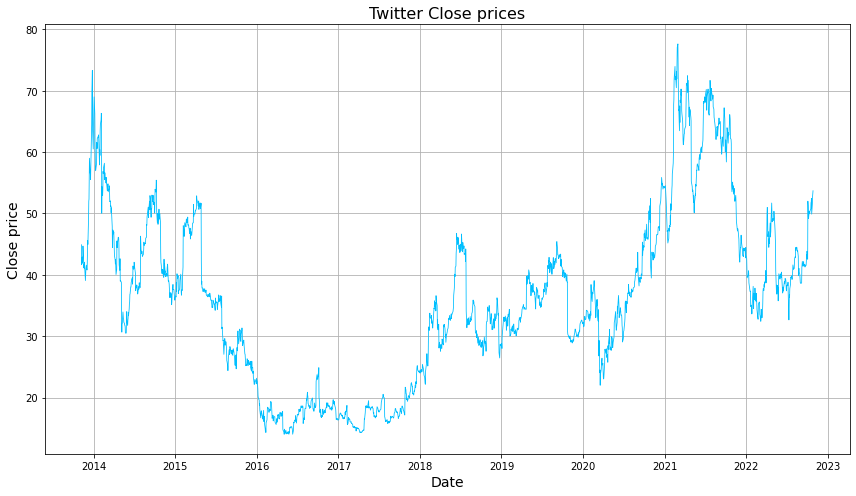

In [12]:
plt.figure(figsize = (12, 7))

plt.plot(twitter_df['Date'].values, twitter_df['Close'].values, linestyle='-', color='deepskyblue', lw = 0.8)
plt.title('Twitter Close prices', fontsize = 16)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Close price', fontsize = 14)
plt.grid(True)
plt.tight_layout()
plt.show()

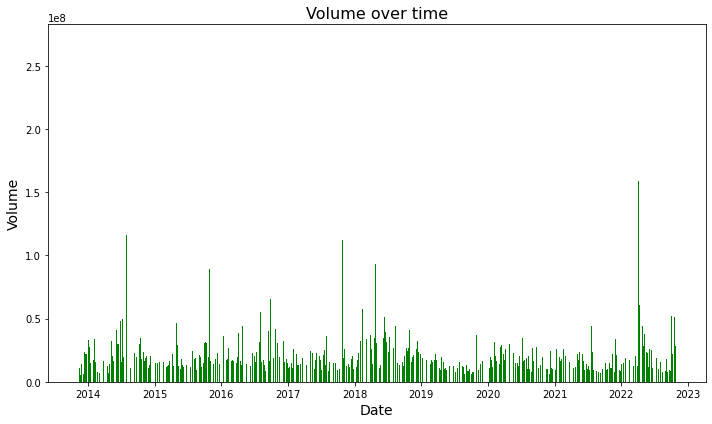

In [13]:
plt.figure(figsize=(10, 6))

plt.bar(twitter_df['Date'], twitter_df['Volume'], color='g')
plt.title("Volume over time" , fontsize = 16)
plt.ylabel('Volume', fontsize = 14)
plt.xlabel('Date', fontsize = 14)
plt.tight_layout()
plt.show()

### Close stock prices

In [14]:
from_date = "2016-01-04"
to_date = "2021-12-31"

twitter_df_2016_2021 = twitter_df.loc[(twitter_df["Date"] >= from_date) 
                                        & (twitter_df["Date"] < to_date)]

In [15]:
twitter_df_final = twitter_df_2016_2021.reset_index(drop=True)

In [16]:
twitter_df_final.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-04,22.639999,22.840000,22.110001,22.559999,22.559999,15308466.0
1,2016-01-05,22.790001,23.000000,21.850000,21.920000,21.920000,17006354.0
2,2016-01-06,21.620001,22.180000,21.180000,21.389999,21.389999,14018839.0
3,2016-01-07,21.000000,21.480000,20.198000,20.260000,20.260000,20737827.0
4,2016-01-08,20.510000,20.719999,19.600000,19.980000,19.980000,21807661.0


### Close prices - 5 years term

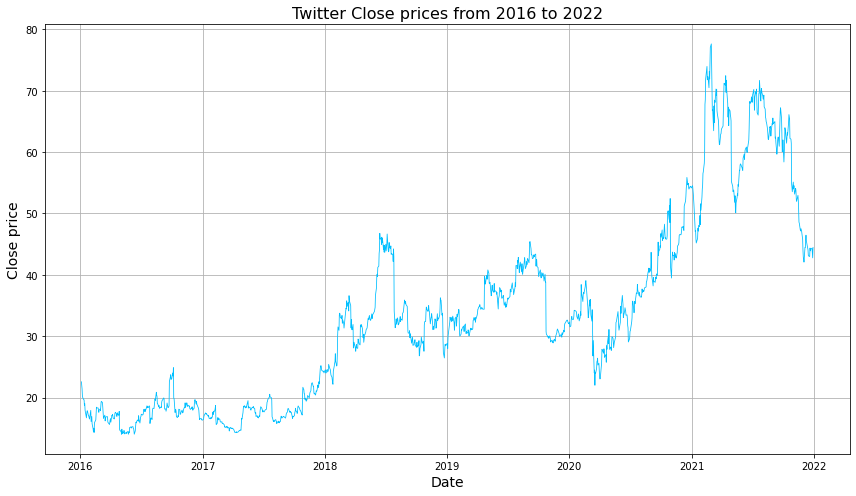

In [17]:
plt.figure(figsize=(12, 7))

plt.plot(twitter_df_final['Date'].values, twitter_df_final['Close'].values, linestyle='-', color='deepskyblue', lw = 0.8)
plt.title('Twitter Close prices from 2016 to 2022', fontsize = 16)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Close price', fontsize = 14)
plt.grid(True)
plt.tight_layout()
plt.show()

### Train and test

In [18]:
data_length = len(twitter_df_final)
split_rate = 0.8

train_length = round(data_length * split_rate)
validation_length = data_length - train_length

In [19]:
data_length, train_length, validation_length

(1510, 1208, 302)

In [20]:
train_data = twitter_df_final[:train_length].iloc[:,::4]
validation_data = twitter_df_final[train_length:].iloc[:,::4]

In [21]:
train_set = train_data.Close.values

In [22]:
train_set = train_set.reshape(-1,1)

In [23]:
train_set.shape

(1208, 1)

### Scaling to obtain values between 0 and 1

In [24]:
trainingScaler = MinMaxScaler(feature_range=(0,1))
close_prices_scaled = trainingScaler.fit_transform(train_set)

In [25]:
close_prices_scaled

array([[0.24970791],
       [0.23101636],
       [0.21553735],
       ...,
       [0.93516352],
       [0.92873835],
       [0.92903037]])

### X_train, y_train

In [26]:
X_train = []
y_train = []

step = 50

for i in range(step, train_length):
    X_train.append(close_prices_scaled[i-step:i, 0])
    y_train.append(close_prices_scaled[i, 0])

In [27]:
X_train, y_train = np.array(X_train), np.array(y_train)

In [28]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

In [29]:
print(X_train.shape, y_train.shape)

(1158, 50, 1) (1158, 1)


### Test data

In [30]:
valid_set = validation_data.Close.values
valid_set = valid_set.reshape(-1, 1)
scaled_valid = trainingScaler.fit_transform(valid_set)

In [31]:
X_test = []
y_test = []

for i in range(step, validation_length):
    X_test.append(scaled_valid[i-step:i, 0])
    y_test.append(scaled_valid[i, 0])

In [32]:
X_test, y_test = np.array(X_test), np.array(y_test)

In [33]:
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_test = y_test.reshape((-1, 1))

In [34]:
print(X_test.shape, y_test.shape)

(252, 50, 1) (252, 1)


## RNN

### LSTM

In [35]:
twt_model_lstm = Sequential()

twt_model_lstm.add(LSTM(units = 50, activation = "tanh", return_sequences = True, input_shape = (X_train.shape[1], 1)))
twt_model_lstm.add(Dropout(0.2))

twt_model_lstm.add(LSTM(units = 50, activation = "tanh", return_sequences = True))
twt_model_lstm.add(Dropout(0.2))

twt_model_lstm.add(LSTM(units = 50, activation = "tanh", return_sequences = True))
twt_model_lstm.add(Dropout(0.2))

twt_model_lstm.add(LSTM(units = 50, return_sequences = False))
twt_model_lstm.add(Dropout(0.2))

twt_model_lstm.add(Dense(1))

In [36]:
twt_model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 50, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [37]:
twt_model_lstm.compile(optimizer = 'adam', 
                       loss = 'mean_squared_error',
                       metrics = ['accuracy'])

In [38]:
history_twt_lstm = twt_model_lstm.fit(X_train, y_train, 
                                      epochs = 50,
                                      batch_size = 32,
                                      verbose = 0)

### Loss

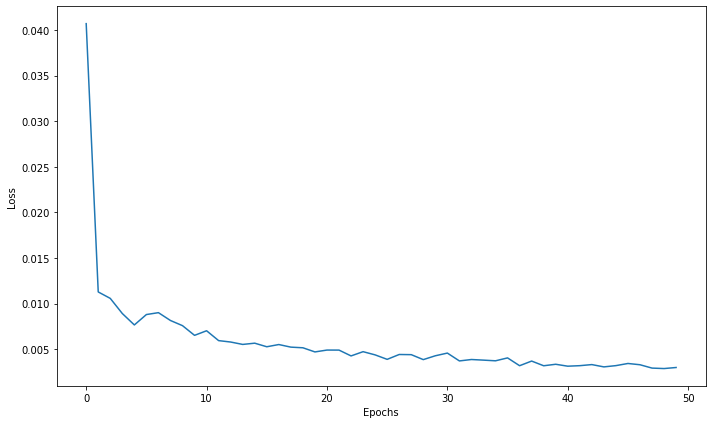

In [39]:
plt.figure(figsize = (10, 6))

plt.plot(history_twt_lstm.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

In [40]:
y_train_pred = twt_model_lstm.predict(X_train)
y_train_pred = trainingScaler.inverse_transform(y_train_pred)

37/37 [==============================] - 3s 24ms/step


In [41]:
y_train_sc_ltsm = trainingScaler.inverse_transform(y_train)

### Predictions - validation data

In [42]:
y_pred_test = twt_model_lstm.predict(X_test)
y_pred_test = trainingScaler.inverse_transform(y_pred_test) 

8/8 [==============================] - 0s 26ms/step


In [43]:
y_test_sc_lstm = trainingScaler.inverse_transform(y_test)

### Visualization

In [44]:
test_dates = twitter_df_final[train_length:]['Date']

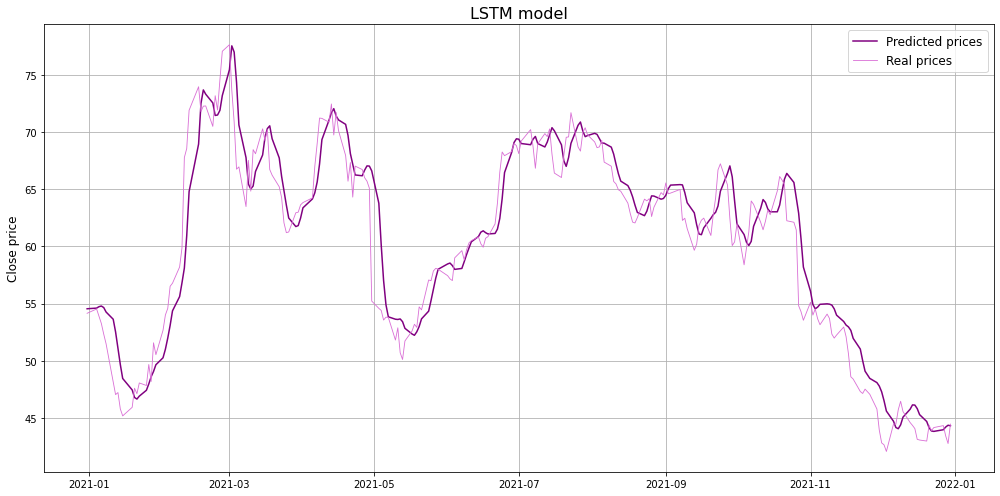

In [45]:
plt.figure(figsize = (14, 7))

plt.plot(test_dates.values[step:], y_pred_test, label = "Predicted prices", c = "purple")
plt.plot(test_dates.values[step:], y_test_sc_lstm, label = "Real prices", c = "orchid", lw = 0.85)
plt.ylabel("Close price", fontsize = 12)
plt.title("LSTM model", fontsize = 16)
plt.legend(fontsize = 12)
plt.grid()
plt.tight_layout()
plt.show()

### MSE

In [46]:
print(mean_squared_error(y_test_sc_lstm, y_pred_test))

6.934371985709967


### MAE

In [47]:
mae_lstm = tf.keras.losses.MeanAbsoluteError()
mae_lstm = mae_lstm(y_test_sc_lstm, y_pred_test).numpy()
mae_lstm

1.9503068

### RMSE

In [48]:
rmse_lstm = math.sqrt(mean_squared_error(y_test_sc_lstm, y_pred_test))
rmse_lstm

2.633319575309834

## SimpleRNN

In [49]:
twit_simp_rnn = Sequential()

twit_simp_rnn.add(SimpleRNN(units = 50, activation = "tanh", return_sequences = True, input_shape = (X_train.shape[1], 1)))
twit_simp_rnn.add(Dropout(0.2))

twit_simp_rnn.add(SimpleRNN(units = 50, activation = "tanh", return_sequences = True))
twit_simp_rnn.add(Dropout(0.2))

twit_simp_rnn.add(SimpleRNN(units = 50, activation = "tanh", return_sequences = True))
twit_simp_rnn.add(Dropout(0.2))

twit_simp_rnn.add(SimpleRNN(units = 50, return_sequences = False))
twit_simp_rnn.add(Dropout(0.2))

twit_simp_rnn.add(Dense(1))

In [50]:
twit_simp_rnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50, 50)            2600      
                                                                 
 dropout_4 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50, 50)            5050      
                                                                 
 dropout_5 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 50, 50)            5050      
                                                                 
 dropout_6 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 50)               

In [51]:
twit_simp_rnn.compile(optimizer = 'adam', 
                      loss = 'mean_squared_error',
                      metrics = ['accuracy'])

In [52]:
history_twt_simple_rnn = twit_simp_rnn.fit(X_train, y_train, 
                                           epochs = 50, 
                                           batch_size = 32,
                                           verbose = 0)

### Loss

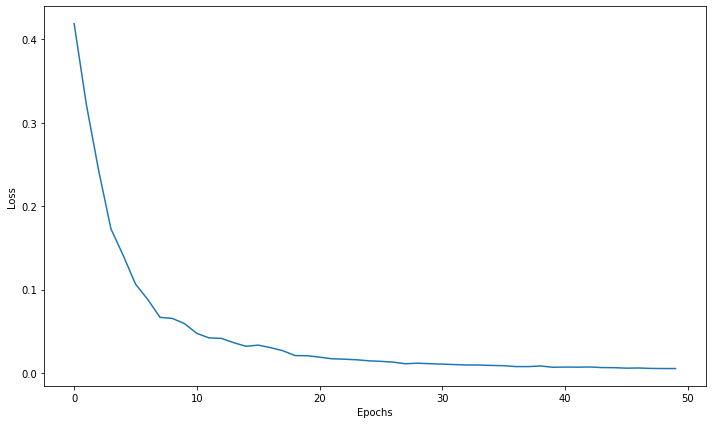

In [53]:
plt.figure(figsize = (10, 6))

plt.plot(history_twt_simple_rnn.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

### Predictions - validation data

In [54]:
y_pred_test_simp_rnn = twit_simp_rnn.predict(X_test)
y_pred_test_simp_rnn = trainingScaler.inverse_transform(y_pred_test_simp_rnn)

8/8 [==============================] - 1s 10ms/step


In [55]:
y_test_sc = trainingScaler.inverse_transform(y_test)

### Visualization

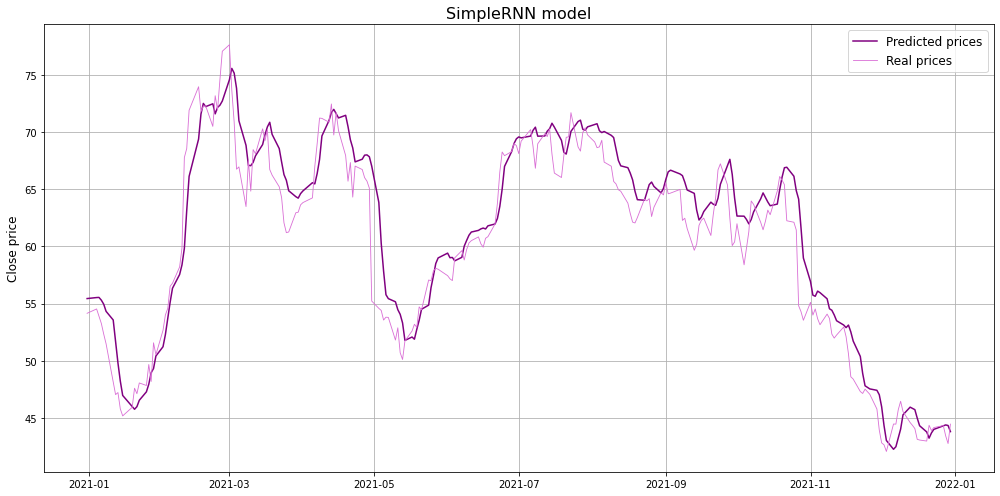

In [56]:
plt.figure(figsize = (14, 7))

plt.plot(test_dates.values[step:], y_pred_test_simp_rnn, label = "Predicted prices", c = "purple")
plt.plot(test_dates.values[step:], y_test_sc, label = "Real prices", c = "orchid", lw = 0.85)
plt.ylabel("Close price", fontsize = 12)
plt.title("SimpleRNN model", fontsize = 16)
plt.legend(fontsize = 12)
plt.grid()
plt.tight_layout()
plt.show()

### MAE

In [57]:
mae_simp_rnn = tf.keras.losses.MeanAbsoluteError()
mae_simp_rnn = mae_simp_rnn(y_test_sc, y_pred_test_simp_rnn).numpy()
mae_simp_rnn

2.0207756

### MSE

In [58]:
print(mean_squared_error(y_test_sc, y_pred_test_simp_rnn))

7.18016842427137


### RMSE

In [59]:
rmse_simple_rnn = math.sqrt(mean_squared_error(y_test_sc, y_pred_test_simp_rnn))
rmse_simple_rnn

2.6795836289004624

## GRU

In [60]:
twt_gru = Sequential()

twt_gru.add(GRU(units=50, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], 1)))
twt_gru.add(Dropout(0.2))

twt_gru.add(GRU(units=50, return_sequences=True, activation='tanh'))
twt_gru.add(Dropout(0.2))

twt_gru.add(GRU(units=50, return_sequences=True, activation='tanh'))
twt_gru.add(Dropout(0.2))

twt_gru.add(GRU(units=50, return_sequences = False))
twt_gru.add(Dropout(0.2))

twt_gru.add(Dense(1))

In [61]:
twt_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 50, 50)            7950      
                                                                 
 dropout_8 (Dropout)         (None, 50, 50)            0         
                                                                 
 gru_1 (GRU)                 (None, 50, 50)            15300     
                                                                 
 dropout_9 (Dropout)         (None, 50, 50)            0         
                                                                 
 gru_2 (GRU)                 (None, 50, 50)            15300     
                                                                 
 dropout_10 (Dropout)        (None, 50, 50)            0         
                                                                 
 gru_3 (GRU)                 (None, 50)               

In [62]:
twt_gru.compile(optimizer = 'adam', 
                loss = 'mean_squared_error',
                metrics = ['accuracy'])

In [63]:
history_twt_gru = twt_gru.fit(X_train, y_train, 
                              epochs = 50, 
                              batch_size = 32,
                              verbose = 0)

### Loss

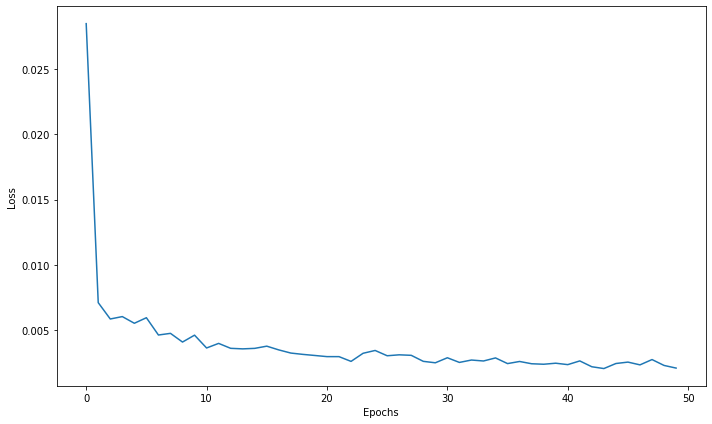

In [64]:
plt.figure(figsize = (10, 6))

plt.plot(history_twt_gru.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

### Predictions - validation data

In [65]:
y_pred_test_gru = twt_gru.predict(X_test)
y_pred_test_gru = trainingScaler.inverse_transform(y_pred_test_gru) 

8/8 [==============================] - 2s 23ms/step


In [66]:
y_test_sc_gru = trainingScaler.inverse_transform(y_test)

### Final visualization

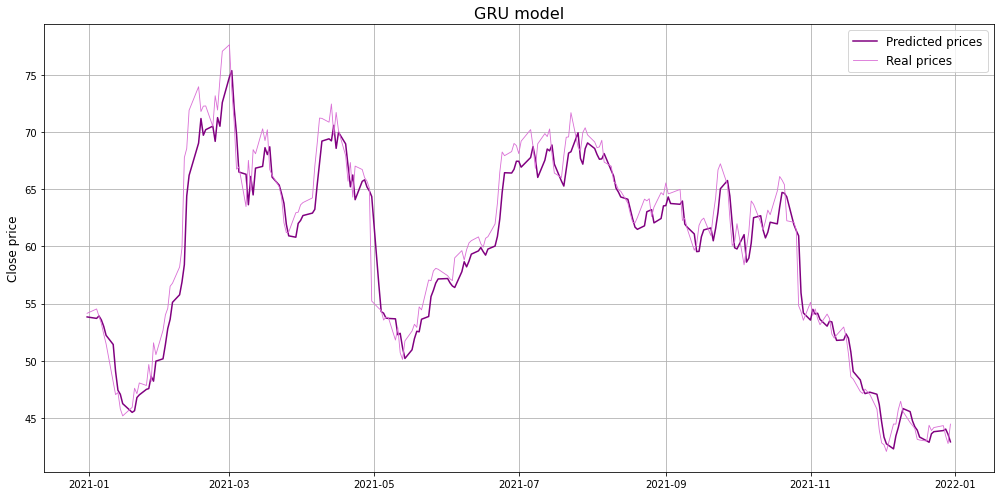

In [67]:
plt.figure(figsize = (14, 7))

plt.plot(test_dates.values[step:], y_pred_test_gru, label = "Predicted prices", c = "purple")
plt.plot(test_dates.values[step:], y_test_sc_gru, label = "Real prices", c = "orchid", lw = 0.85)
plt.ylabel("Close price", fontsize = 12)
plt.title("GRU model", fontsize = 16)
plt.legend(fontsize = 12)
plt.grid()
plt.tight_layout()
plt.show()

### MAE

In [68]:
mae_gru = tf.keras.losses.MeanAbsoluteError()
mae_gru = mae_gru(y_test_sc_gru, y_pred_test_gru).numpy()
mae_gru

1.4934084

### MSE

In [69]:
print(mean_squared_error(y_test_sc_gru, y_pred_test_gru))

3.9845447639825675


### RMSE

In [70]:
rmse_gru = math.sqrt(mean_squared_error(y_test_sc_gru, y_pred_test_gru))
rmse_gru

1.9961324515128167

## Tuning - SimpleRNN

In [71]:
def model_builder(hp):
    model = Sequential()
    
    model.add(SimpleRNN(hp.Int('units_1', min_value=32, max_value=128, step=32), 
                        activation = hp.Choice('simple_rnn_1_activation', values=['relu', 'sigmoid', 'tanh']), 
                        return_sequences=True, 
                        input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(hp.Float('Dropout_rate_1', min_value=0, max_value=0.5, step=0.1)))

    model.add(SimpleRNN(hp.Int('units_2', min_value=32, max_value=128, step=32),
                        activation = hp.Choice('simple_rnn_2_activation', values=['relu', 'sigmoid', 'tanh']), 
                        return_sequences = True))
    model.add(Dropout(hp.Float('Dropout_rate_2', min_value=0, max_value=0.5, step=0.1)))

    model.add(SimpleRNN(hp.Int('units_3', min_value=32, max_value=128, step=32),
                        activation = hp.Choice('simple_rnn_3_activation', values=['relu', 'sigmoid', 'tanh']), 
                        return_sequences = True))
    model.add(Dropout(hp.Float('Dropout_rate_3', min_value=0, max_value=0.5, step=0.1)))

    model.add(SimpleRNN(hp.Int('units_4', min_value=32, max_value=128, step=32),
                        return_sequences = False))
    model.add(Dropout(hp.Float('Dropout_rate_4', min_value=0, max_value=0.5, step=0.1)))

    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error', 
                  optimizer='adam',
                  metrics = ['accuracy'])
    
    return model

In [72]:
tuner = kt.RandomSearch(
            model_builder,
            objective='val_loss',
            directory = 'SimpleRNN_more_trials',
            project_name = 'SimpleRNN_more_trials',
            max_trials = 20,
            max_consecutive_failed_trials = 3)

In [73]:
tuner.search(
        X_train,
        y_train,
        epochs = 50,
        batch_size = 32,
        validation_data = (X_test, y_test)
)

Trial 20 Complete [00h 02m 09s]
val_loss: 0.006152756977826357

Best val_loss So Far: 0.0032807528041303158
Total elapsed time: 00h 43m 55s


In [74]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
best_model = tuner.get_best_models(num_models = 1)[0]

In [75]:
simple_rnn_tuned_build = tuner.hypermodel.build(best_hps)
history_simp_rnn_tuned = simple_rnn_tuned_build.fit(X_train, y_train, epochs = 50, validation_split = 0.2)

Epoch 1/50
29/29 [==============================] - 5s 68ms/step - loss: 0.5896 - accuracy: 0.0000e+00 - val_loss: 0.0253 - val_accuracy: 0.0043
Epoch 2/50
29/29 [==============================] - 2s 54ms/step - loss: 0.3205 - accuracy: 0.0011 - val_loss: 0.0149 - val_accuracy: 0.0043
Epoch 3/50
29/29 [==============================] - 2s 55ms/step - loss: 0.2210 - accuracy: 0.0011 - val_loss: 0.0042 - val_accuracy: 0.0043
Epoch 4/50
29/29 [==============================] - 2s 53ms/step - loss: 0.1974 - accuracy: 0.0011 - val_loss: 0.0150 - val_accuracy: 0.0043
Epoch 5/50
29/29 [==============================] - 2s 52ms/step - loss: 0.1467 - accuracy: 0.0011 - val_loss: 0.0119 - val_accuracy: 0.0043
Epoch 6/50
29/29 [==============================] - 2s 54ms/step - loss: 0.1100 - accuracy: 0.0011 - val_loss: 0.0139 - val_accuracy: 0.0043
Epoch 7/50
29/29 [==============================] - 2s 54ms/step - loss: 0.0992 - accuracy: 0.0011 - val_loss: 0.0045 - val_accuracy: 0.0043
Epoch 8/5

### Loss

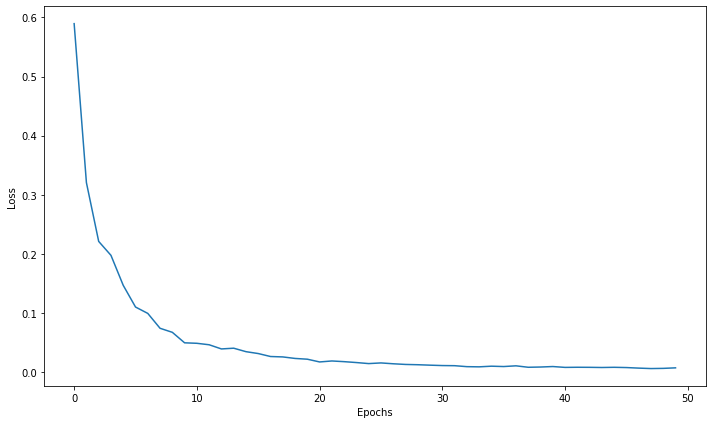

In [76]:
plt.figure(figsize = (10, 6))

plt.plot(history_simp_rnn_tuned.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

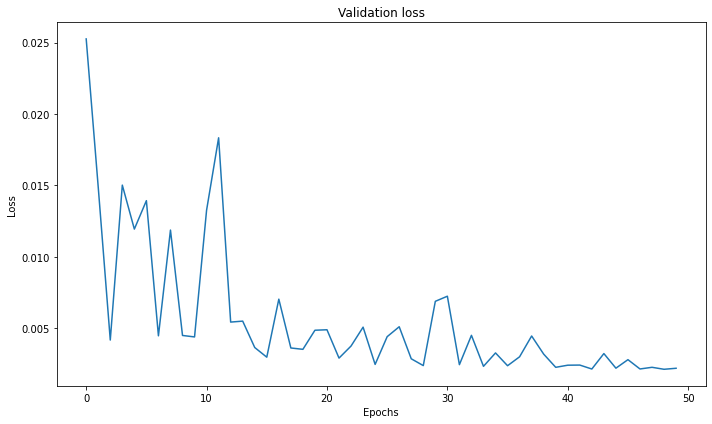

In [77]:
plt.figure(figsize = (10, 6))

plt.plot(history_simp_rnn_tuned.history['val_loss'])
plt.title("Validation loss")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

In [78]:
tuner.results_summary(1)

Results summary
Results in SimpleRNN_more_trials\SimpleRNN_more_trials
Showing 1 best trials
Objective(name="val_loss", direction="min")

Trial 16 summary
Hyperparameters:
units_1: 96
simple_rnn_1_activation: tanh
Dropout_rate_1: 0.1
units_2: 32
simple_rnn_2_activation: tanh
Dropout_rate_2: 0.0
units_3: 32
simple_rnn_3_activation: tanh
Dropout_rate_3: 0.4
units_4: 32
Dropout_rate_4: 0.2
Score: 0.0032807528041303158


In [79]:
best_hps.values

{'units_1': 96,
 'simple_rnn_1_activation': 'tanh',
 'Dropout_rate_1': 0.1,
 'units_2': 32,
 'simple_rnn_2_activation': 'tanh',
 'Dropout_rate_2': 0.0,
 'units_3': 32,
 'simple_rnn_3_activation': 'tanh',
 'Dropout_rate_3': 0.4,
 'units_4': 32,
 'Dropout_rate_4': 0.2}

### Predictions

In [80]:
best_simpleRNN_model_pred = best_model.predict(X_test)

8/8 [==============================] - 1s 10ms/step


In [81]:
best_simpleRNN_model_pred_train = best_model.predict(X_train)

37/37 [==============================] - 0s 11ms/step


In [82]:
best_simpleRNN_model_pred = trainingScaler.inverse_transform(best_simpleRNN_model_pred)

### Visualization

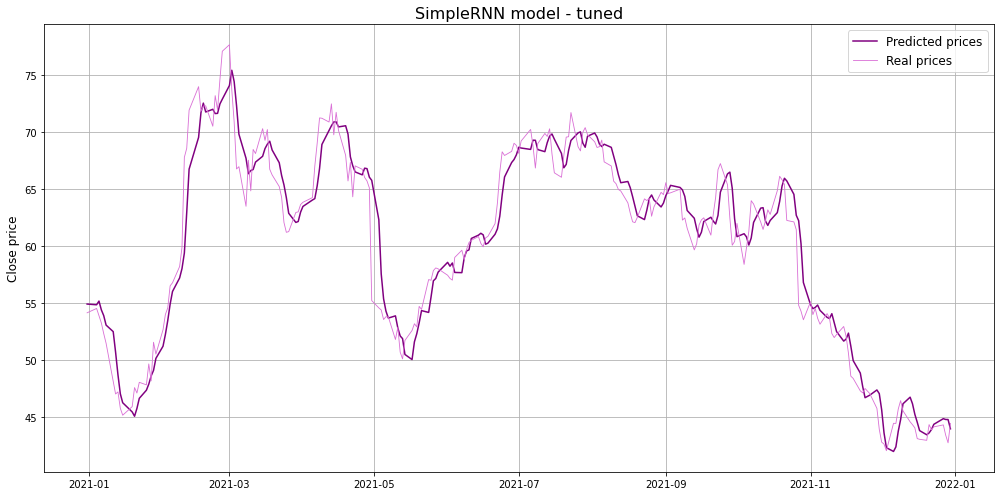

In [83]:
plt.figure(figsize = (14, 7))

plt.plot(test_dates.values[step:], best_simpleRNN_model_pred, label = "Predicted prices", c = "purple")
plt.plot(test_dates.values[step:], y_test_sc, label = "Real prices", c = "orchid", lw = 0.85)
plt.ylabel("Close price", fontsize = 12)
plt.title("SimpleRNN model - tuned", fontsize = 16)
plt.legend(fontsize = 12)
plt.grid()
plt.tight_layout()
plt.show()

### MAE

In [84]:
mae_simp_rnn_tuned = tf.keras.losses.MeanAbsoluteError()
mae_simp_rnn_tuned = mae_simp_rnn_tuned(y_test_sc_gru, best_simpleRNN_model_pred).numpy()
mae_simp_rnn_tuned

1.6385752

### RMSE

In [85]:
rmse_tuned_simp_rnn = math.sqrt(mean_squared_error(y_test_sc, best_simpleRNN_model_pred))
rmse_tuned_simp_rnn

2.1857226683956754

## GRU model - tuning

In [86]:
def build_rnn(hp):
    model = Sequential()
    
    model.add(GRU(hp.Int('units_1', min_value=32, max_value=128, step=32), 
                        activation = hp.Choice('gru_1_activation', values=['relu', 'sigmoid', 'tanh']), 
                        return_sequences=True, 
                        input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(hp.Float('Dropout_rate_1', min_value=0, max_value=0.5, step=0.1)))

    model.add(GRU(hp.Int('units_2', min_value=32, max_value=128, step=32),
                        activation = hp.Choice('gru_2_activation', values=['relu', 'sigmoid', 'tanh']), 
                        return_sequences = True))
    model.add(Dropout(hp.Float('Dropout_rate_2', min_value=0, max_value=0.5, step=0.1)))

    model.add(GRU(hp.Int('units_3', min_value=32, max_value=128, step=32),
                        activation = hp.Choice('gru_3_activation', values=['relu', 'sigmoid', 'tanh']), 
                        return_sequences = True))
    model.add(Dropout(hp.Float('Dropout_rate_3', min_value=0, max_value=0.5, step=0.1)))

    model.add(GRU(hp.Int('units_4', min_value=32, max_value=128, step=32), 
                        return_sequences = False))
    model.add(Dropout(hp.Float('Dropout_rate_4', min_value=0, max_value=0.5, step=0.1)))

    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error', 
                  optimizer='adam',
                  metrics = ['accuracy'])
    
    return model

In [87]:
tuner_gru = kt.RandomSearch(
                build_rnn,
                objective='val_loss',
                directory = 'GRU_more_trials',
                project_name = 'GRU_more_trials',
                max_trials = 20,
                max_consecutive_failed_trials = 3)

In [88]:
tuner_gru.search(
            X_train,
            y_train,
            epochs = 50,
            batch_size = 32,
            validation_data = (X_test, y_test)
)

Trial 20 Complete [00h 03m 14s]
val_loss: 0.0021690211724489927

Best val_loss So Far: 0.0021690211724489927
Total elapsed time: 01h 04m 27s


In [89]:
tuner_gru.results_summary(1)

Results summary
Results in GRU_more_trials\GRU_more_trials
Showing 1 best trials
Objective(name="val_loss", direction="min")

Trial 19 summary
Hyperparameters:
units_1: 128
gru_1_activation: relu
Dropout_rate_1: 0.0
units_2: 96
gru_2_activation: sigmoid
Dropout_rate_2: 0.0
units_3: 128
gru_3_activation: tanh
Dropout_rate_3: 0.1
units_4: 64
Dropout_rate_4: 0.0
Score: 0.0021690211724489927


In [90]:
best_hps_gru = tuner_gru.get_best_hyperparameters(num_trials = 1)[0]
best_model_gru = tuner_gru.get_best_models(num_models = 1)[0]

In [91]:
gru_tuned_build = tuner_gru.hypermodel.build(best_hps_gru)
history_gru_tuned = gru_tuned_build.fit(X_train, y_train, epochs = 50, validation_split = 0.2)

Epoch 1/50
29/29 [==============================] - 9s 133ms/step - loss: 0.1139 - accuracy: 0.0011 - val_loss: 0.0961 - val_accuracy: 0.0000e+00
Epoch 2/50
29/29 [==============================] - 3s 100ms/step - loss: 0.0307 - accuracy: 0.0011 - val_loss: 0.0059 - val_accuracy: 0.0043
Epoch 3/50
29/29 [==============================] - 3s 103ms/step - loss: 0.0086 - accuracy: 0.0011 - val_loss: 0.0053 - val_accuracy: 0.0043
Epoch 4/50
29/29 [==============================] - 3s 102ms/step - loss: 0.0050 - accuracy: 0.0011 - val_loss: 0.0046 - val_accuracy: 0.0043
Epoch 5/50
29/29 [==============================] - 3s 101ms/step - loss: 0.0040 - accuracy: 0.0011 - val_loss: 0.0038 - val_accuracy: 0.0043
Epoch 6/50
29/29 [==============================] - 3s 100ms/step - loss: 0.0036 - accuracy: 0.0011 - val_loss: 0.0034 - val_accuracy: 0.0043
Epoch 7/50
29/29 [==============================] - 3s 102ms/step - loss: 0.0035 - accuracy: 0.0011 - val_loss: 0.0032 - val_accuracy: 0.0043
Ep

In [92]:
best_hps_gru.values

{'units_1': 128,
 'gru_1_activation': 'relu',
 'Dropout_rate_1': 0.0,
 'units_2': 96,
 'gru_2_activation': 'sigmoid',
 'Dropout_rate_2': 0.0,
 'units_3': 128,
 'gru_3_activation': 'tanh',
 'Dropout_rate_3': 0.1,
 'units_4': 64,
 'Dropout_rate_4': 0.0}

### Predictions

In [93]:
best_gru_model_pred = best_model_gru.predict(X_test)

8/8 [==============================] - 1s 23ms/step


In [94]:
best_gru_model_pred_train = best_model.predict(X_train)

37/37 [==============================] - 1s 8ms/step


In [95]:
best_gru_model_pred = trainingScaler.inverse_transform(best_gru_model_pred)

### Loss

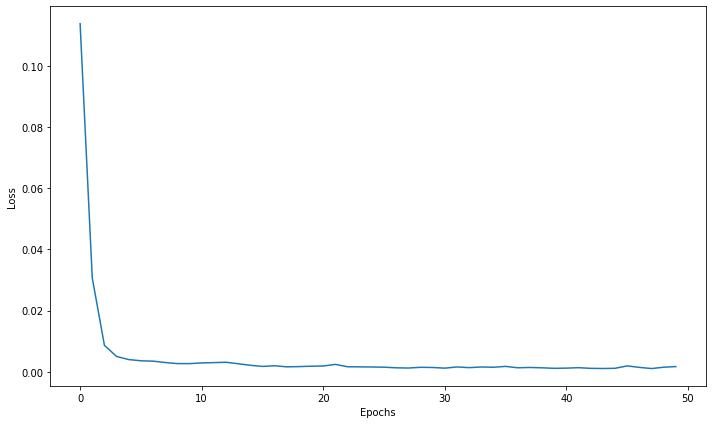

In [96]:
plt.figure(figsize = (10, 6))

plt.plot(history_gru_tuned.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

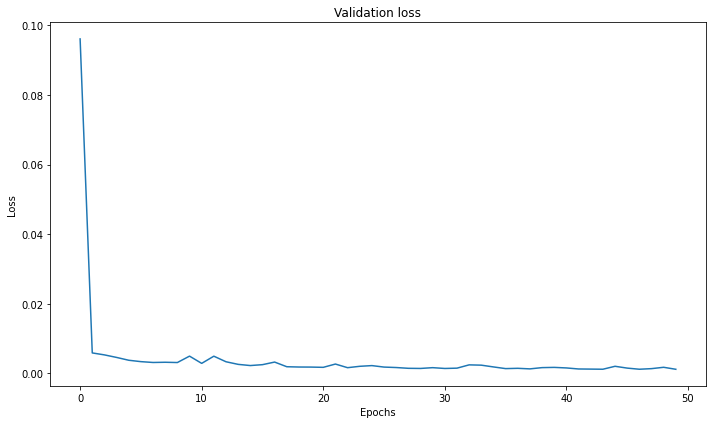

In [97]:
plt.figure(figsize = (10, 6))

plt.plot(history_gru_tuned.history['val_loss'])
plt.title("Validation loss")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

### Visualization

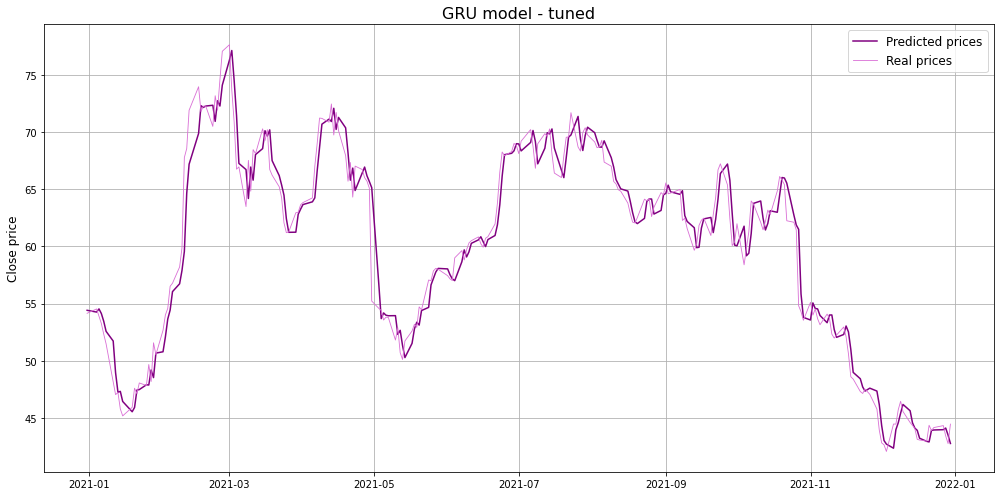

In [98]:
plt.figure(figsize = (14, 7))

plt.plot(test_dates.values[step:], best_gru_model_pred, label = "Predicted prices", c = "purple")
plt.plot(test_dates.values[step:], y_test_sc_gru, label = "Real prices", c = "orchid", lw = 0.85)
plt.ylabel("Close price", fontsize = 12)
plt.title("GRU model - tuned", fontsize = 16)
plt.legend(fontsize = 12)
plt.grid()
plt.tight_layout()
plt.show()

### MAE

In [99]:
mae_gru_tuned = tf.keras.losses.MeanAbsoluteError()
mae_gru_tuned = mae_gru_tuned(y_test_sc_gru, best_gru_model_pred).numpy()
mae_gru_tuned

1.2706586

### RMSE

In [100]:
rmse_gru_tuned = math.sqrt(mean_squared_error(y_test_sc_gru, best_gru_model_pred))
rmse_gru_tuned

1.7772157811637415

## LSTM - tuning

In [101]:
def build_lstm(hp):
    model = Sequential()
    
    model.add(LSTM(hp.Int('units_1', min_value=32, max_value=128, step=32), 
                        activation = hp.Choice('lstm_1_activation', values=['relu', 'sigmoid', 'tanh']), 
                        return_sequences=True, 
                        input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(hp.Float('Dropout_rate_1', min_value=0, max_value=0.5, step=0.1)))

    model.add(LSTM(hp.Int('units_2', min_value=32, max_value=128, step=32),
                        activation = hp.Choice('lstm_2_activation', values=['relu', 'sigmoid', 'tanh']), 
                        return_sequences = True))
    model.add(Dropout(hp.Float('Dropout_rate_2', min_value=0, max_value=0.5, step=0.1)))

    model.add(LSTM(hp.Int('units_3', min_value=32, max_value=128, step=32),
                        activation = hp.Choice('lstm_3_activation', values=['relu', 'sigmoid', 'tanh']), 
                        return_sequences = True))
    model.add(Dropout(hp.Float('Dropout_rate_3', min_value=0, max_value=0.5, step=0.1)))

    model.add(LSTM(hp.Int('units_4', min_value=32, max_value=128, step=32), 
                        return_sequences = False))
    model.add(Dropout(hp.Float('Dropout_rate_4', min_value=0, max_value=0.5, step=0.1)))

    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error', 
                  optimizer='adam',
                  metrics = ['accuracy'])
    
    return model

In [102]:
tuner_lstm = kt.RandomSearch(
                build_lstm,
                objective = 'val_loss',
                directory = 'LSTM_more_trials',
                project_name = 'LSTM_more_trials',
                max_trials = 20,
                max_consecutive_failed_trials = 3)

In [103]:
tuner_lstm.search(
        X_train,
        y_train,
        epochs = 50,
        batch_size = 32,
        validation_data = (X_test, y_test)
)

Trial 20 Complete [00h 03m 23s]
val_loss: 0.0026771065313369036

Best val_loss So Far: 0.0026771065313369036
Total elapsed time: 01h 04m 20s


In [104]:
best_hps_lstm = tuner_lstm.get_best_hyperparameters(num_trials = 1)[0]
best_model_lstm = tuner_lstm.get_best_models(num_models = 1)[0]

In [105]:
lstm_tuned_build = tuner_lstm.hypermodel.build(best_hps_lstm)
history_lstm_tuned = lstm_tuned_build.fit(X_train, y_train, epochs = 50, validation_split = 0.2)

Epoch 1/50
29/29 [==============================] - 10s 154ms/step - loss: 0.0276 - accuracy: 0.0011 - val_loss: 0.0177 - val_accuracy: 0.0043
Epoch 2/50
29/29 [==============================] - 3s 102ms/step - loss: 0.0085 - accuracy: 0.0011 - val_loss: 0.0099 - val_accuracy: 0.0043
Epoch 3/50
29/29 [==============================] - 3s 104ms/step - loss: 0.0074 - accuracy: 0.0011 - val_loss: 0.0117 - val_accuracy: 0.0043
Epoch 4/50
29/29 [==============================] - 3s 105ms/step - loss: 0.0065 - accuracy: 0.0011 - val_loss: 0.0078 - val_accuracy: 0.0043
Epoch 5/50
29/29 [==============================] - 3s 104ms/step - loss: 0.0056 - accuracy: 0.0011 - val_loss: 0.0064 - val_accuracy: 0.0043
Epoch 6/50
29/29 [==============================] - 3s 105ms/step - loss: 0.0057 - accuracy: 0.0011 - val_loss: 0.0065 - val_accuracy: 0.0043
Epoch 7/50
29/29 [==============================] - 3s 103ms/step - loss: 0.0051 - accuracy: 0.0011 - val_loss: 0.0062 - val_accuracy: 0.0043
Epoch

In [106]:
best_hps_lstm.values

{'units_1': 128,
 'lstm_1_activation': 'tanh',
 'Dropout_rate_1': 0.2,
 'units_2': 96,
 'lstm_2_activation': 'tanh',
 'Dropout_rate_2': 0.2,
 'units_3': 32,
 'lstm_3_activation': 'tanh',
 'Dropout_rate_3': 0.0,
 'units_4': 96,
 'Dropout_rate_4': 0.1}

### Predictions

In [107]:
best_lstm_model_pred = best_model_lstm.predict(X_test)

8/8 [==============================] - 2s 26ms/step


In [108]:
best_lstm_model_pred_train = best_model_lstm.predict(X_train)

37/37 [==============================] - 1s 32ms/step


In [109]:
best_lstm_model_pred = trainingScaler.inverse_transform(best_lstm_model_pred)

### Loss

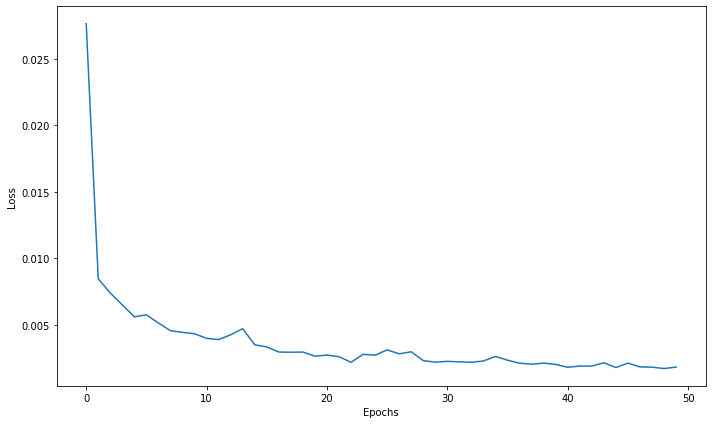

In [110]:
plt.figure(figsize = (10, 6))

plt.plot(history_lstm_tuned.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

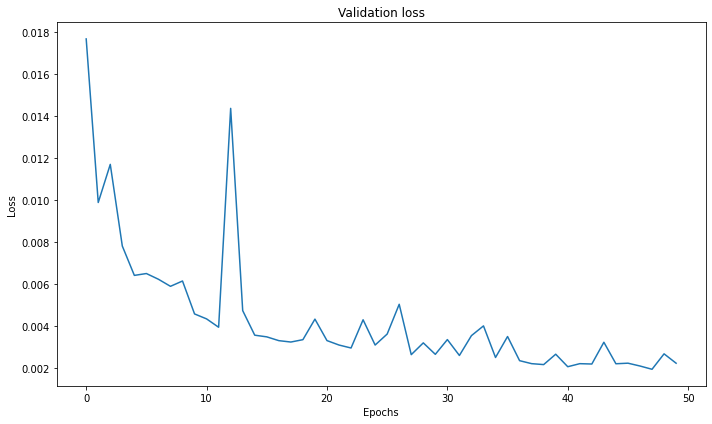

In [111]:
plt.figure(figsize = (10, 6))

plt.plot(history_lstm_tuned.history['val_loss'])
plt.title('Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

### Visualization

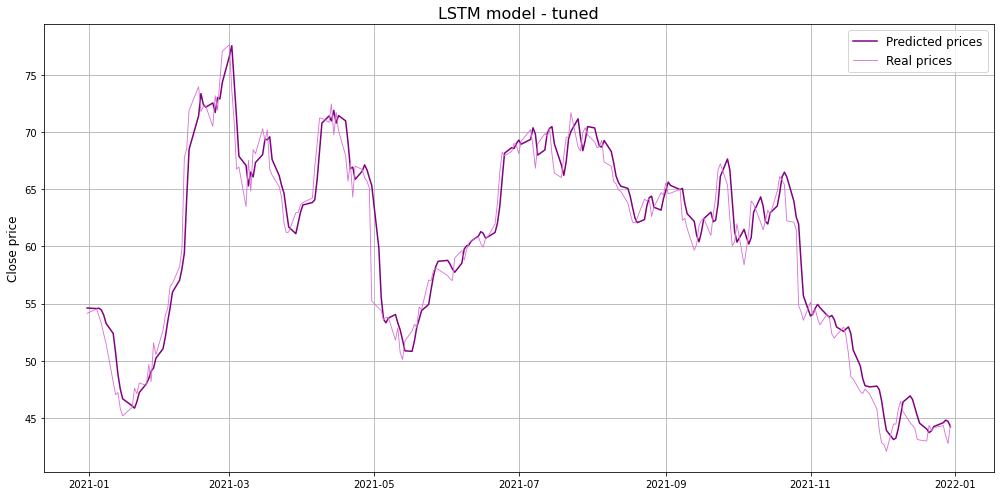

In [112]:
plt.figure(figsize = (14, 7))

plt.plot(test_dates.values[step:], best_lstm_model_pred, label = "Predicted prices", c = "purple")
plt.plot(test_dates.values[step:], y_test_sc_lstm, label = "Real prices", c = "orchid", lw = 0.85)
plt.ylabel("Close price", fontsize = 12)
plt.title("LSTM model - tuned", fontsize = 16)
plt.legend(fontsize = 12)
plt.grid()
plt.tight_layout()
plt.show()

### MAE

In [113]:
mae_lstm_tuned = tf.keras.losses.MeanAbsoluteError()
mae_lstm_tuned = mae_lstm_tuned(y_test_sc_lstm, best_lstm_model_pred).numpy()
mae_lstm_tuned

1.4770658

### RMSE

In [114]:
rmse_ltsm_tuned = math.sqrt(mean_squared_error(y_test_sc_lstm, best_lstm_model_pred))
rmse_ltsm_tuned

1.97442710877518

## MAE, RMSE - summary for all models

In [115]:
data_rmse = {'Model': ['LSTM', 'Tuned LSTM', 'Simple RNN', 'Tuned Simple RNN', 'GRU', 'Tuned GRU'],
            'MAE': [mae_lstm, mae_lstm_tuned, mae_simp_rnn, mae_simp_rnn_tuned, mae_gru, mae_gru_tuned],
        'RMSE': [rmse_lstm, rmse_ltsm_tuned, rmse_simple_rnn, rmse_tuned_simp_rnn, rmse_gru, rmse_gru_tuned]}

df_rmse = pd.DataFrame(data_rmse)
df_rmse

,Model,MAE,RMSE
0,LSTM,1.950307,2.633320
1,Tuned LSTM,1.477066,1.974427
2,Simple RNN,2.020776,2.679584
3,Tuned Simple RNN,1.638575,2.185723
4,GRU,1.493408,1.996132
5,Tuned GRU,1.270659,1.777216
